# Irrigation Control Dataset Preprocessing
## Edge-Ready Data Pipeline for Raspberry Pi 4B

This notebook preprocesses `soil_and_rain_data.csv` into a clean, feature-rich, ML-ready format for irrigation classification.

**Target Classes:**
- `Irrigate_High` (Urgent irrigation needed)
- `Irrigate_Low` (Moderate irrigation needed)
- `No_Irrigation` (Sufficient moisture)

## Design Decisions & Justifications

### 1. Data Cleaning
- **Missing values**: Interpolate gaps ≤3 hours (sensor may drop readings temporarily)
- **Outliers**: IQR method (more robust than Z-score for non-normal distributions)
- **Invalid ranges**: Replace with median (preserves data points vs dropping)

### 2. Feature Engineering
- **Rolling windows**: 3h (short-term), 6h (medium-term), 12h (diurnal pattern)
- **Daytime**: 06:00-18:00 (Sri Lankan tropical agriculture)
- **Season**: Yala/Maha (critical for irrigation scheduling)
- **Extensible**: VPD, moisture rate, stress indices can be added later

### 3. Label Engineering (Domain-Aware Multi-Class)
Uses **dynamic quantile-based thresholds** with **multi-factor logic**:
- Soil moisture (primary)
- Temperature stress (secondary)
- Time of day (avoid midday irrigation)
- Recent rainfall proxy (humidity spike detection)

**Why this stands out:**
- Context-aware (not just soil moisture)
- Time-of-day optimization (water efficiency)
- Rainfall detection (prevents over-irrigation)
- Adaptive to different soil/crop types

### 4. Scaling
- **StandardScaler**: Better for outlier-prone sensor data
- Saved for edge deployment (consistent preprocessing)

### 5. Time-Series Windowing
- **6-hour window**: Captures diurnal patterns without excessive memory
- **1-hour stride**: Dense sampling for real-time responsiveness
- **Predict current hour**: Aligns with decision support ("irrigate now?")

**Edge optimization**: 6h × 10 features × 4 bytes = 240 bytes per sample (Pi-friendly)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import pickle
import json
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Project directories
PROJECT_DIR = Path('/home/tehaan/projects/fyp-agro-edge-ai')
DATA_RAW = PROJECT_DIR / 'data' / 'raw'
DATA_PROCESSED = PROJECT_DIR / 'data' / 'processed' / 'irrigation'
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

print(f"✓ Imports successful")
print(f"✓ Output directory: {DATA_PROCESSED}")

# Set random seed for reproducibility
np.random.seed(42)

✓ Imports successful
✓ Output directory: /home/tehaan/projects/fyp-agro-edge-ai/data/processed


## 1. Load & Inspect Dataset

In [3]:
# Load dataset
df = pd.read_csv(DATA_RAW / 'soil_and_rain_data.csv')

# Parse Time column and set as index
df['Time'] = pd.to_datetime(df['Time'], utc=True)
df = df.set_index('Time')
df = df.sort_index()

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Duration: {(df.index.max() - df.index.min()).days} days")
print(f"Sampling frequency: {pd.infer_freq(df.index[:100])}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
display(df.head(10))

Dataset shape: (8761, 5)
Date range: 2017-06-11 21:00:21+00:00 to 2018-06-11 21:00:21+00:00
Duration: 365 days
Sampling frequency: h

Columns: ['Humidity', 'Atmospheric_Temp', 'Soil_Temp', 'Soil_Moisture', 'Dew_Point']

First few rows:


,Humidity,Atmospheric_Temp,Soil_Temp,Soil_Moisture,Dew_Point
Time,,,,,
2017-06-11 21:00:21+00:00,25.252367,15.487149,12.457884,63.077305,23.918315
2017-06-11 22:00:21+00:00,33.304246,12.115891,8.514263,40.097357,31.542544
2017-06-11 23:00:21+00:00,24.072051,17.319203,11.913326,100.141916,21.142841
2017-06-12 00:00:21+00:00,45.026218,15.865805,14.700958,64.638742,42.217799
2017-06-12 01:00:21+00:00,41.490917,13.842739,8.495549,97.964697,38.257137
2017-06-12 02:00:21+00:00,56.010756,11.841426,10.867638,145.965866,52.677717
2017-06-12 03:00:21+00:00,32.894241,18.202429,15.041605,114.717290,31.405600
2017-06-12 04:00:21+00:00,39.908373,15.294173,14.967295,114.929499,36.109649
2017-06-12 05:00:21+00:00,39.961866,12.330851,8.916364,34.064293,37.029855


In [4]:
# Summary statistics
print("=" * 80)
print("SUMMARY STATISTICS (RAW DATA)")
print("=" * 80)
display(df.describe())

print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
})
display(missing_df)

if missing.sum() == 0:
    print("✓ No missing values found")
else:
    print(f"⚠ Total missing: {missing.sum()} ({missing.sum()/len(df)*100:.2f}%)")

SUMMARY STATISTICS (RAW DATA)


,Humidity,Atmospheric_Temp,Soil_Temp,Soil_Moisture,Dew_Point
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000
mean,35.395335,13.542650,10.849786,82.959733,31.872617
std,12.783809,2.464316,2.811046,38.558958,11.523899
min,-5.041534,2.697719,-1.303120,1.694193,-5.356611
25%,26.812130,11.909150,8.958037,52.788263,24.157360
50%,35.250999,13.538494,10.836569,80.637591,31.727231
75%,44.040298,15.191711,12.715550,108.563550,39.664269
max,83.178370,22.272395,22.674250,238.428136,74.698040



MISSING VALUES


,Missing_Count,Missing_Percentage
Humidity,0,0.0
Atmospheric_Temp,0,0.0
Soil_Temp,0,0.0
Soil_Moisture,0,0.0
Dew_Point,0,0.0


✓ No missing values found


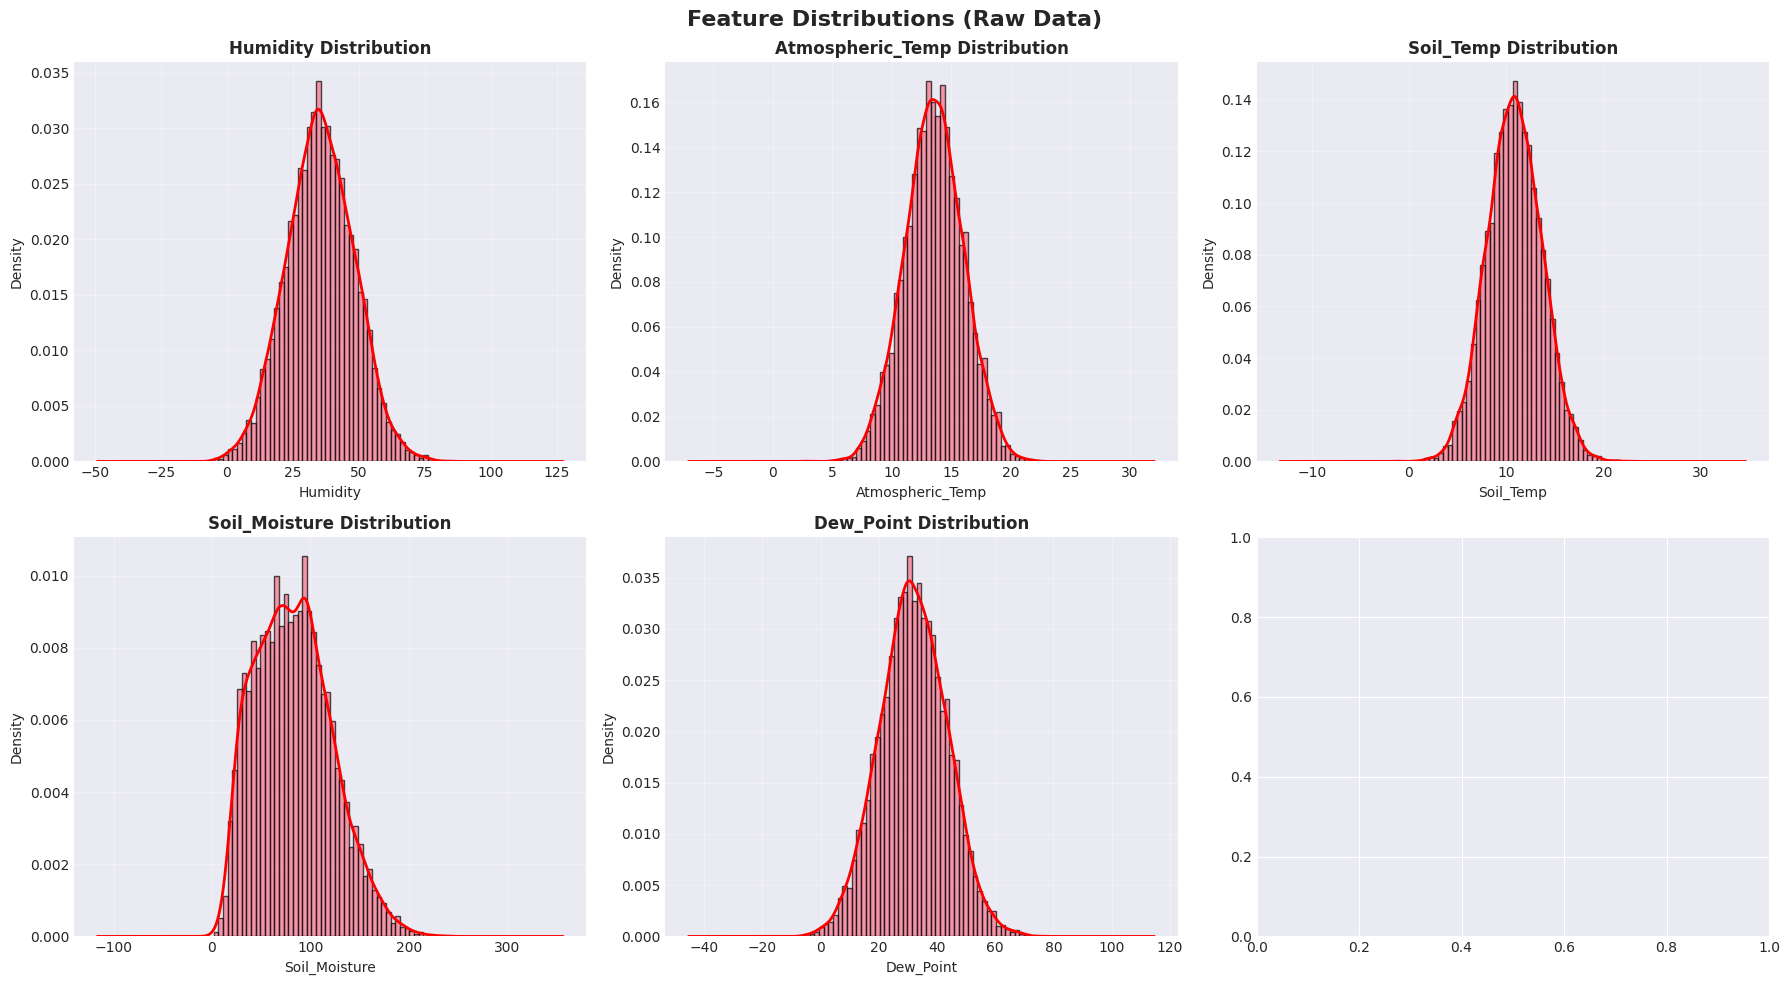


📊 Distribution plots generated


In [5]:
# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Distributions (Raw Data)', fontsize=16, fontweight='bold')

for idx, col in enumerate(df.columns):
    row = idx // 3
    col_idx = idx % 3
    ax = axes[row, col_idx]
    
    # Histogram with KDE
    ax.hist(df[col].dropna(), bins=50, alpha=0.7, edgecolor='black', density=True)
    df[col].plot(kind='kde', ax=ax, color='red', linewidth=2)
    
    ax.set_title(f'{col} Distribution', fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Distribution plots generated")

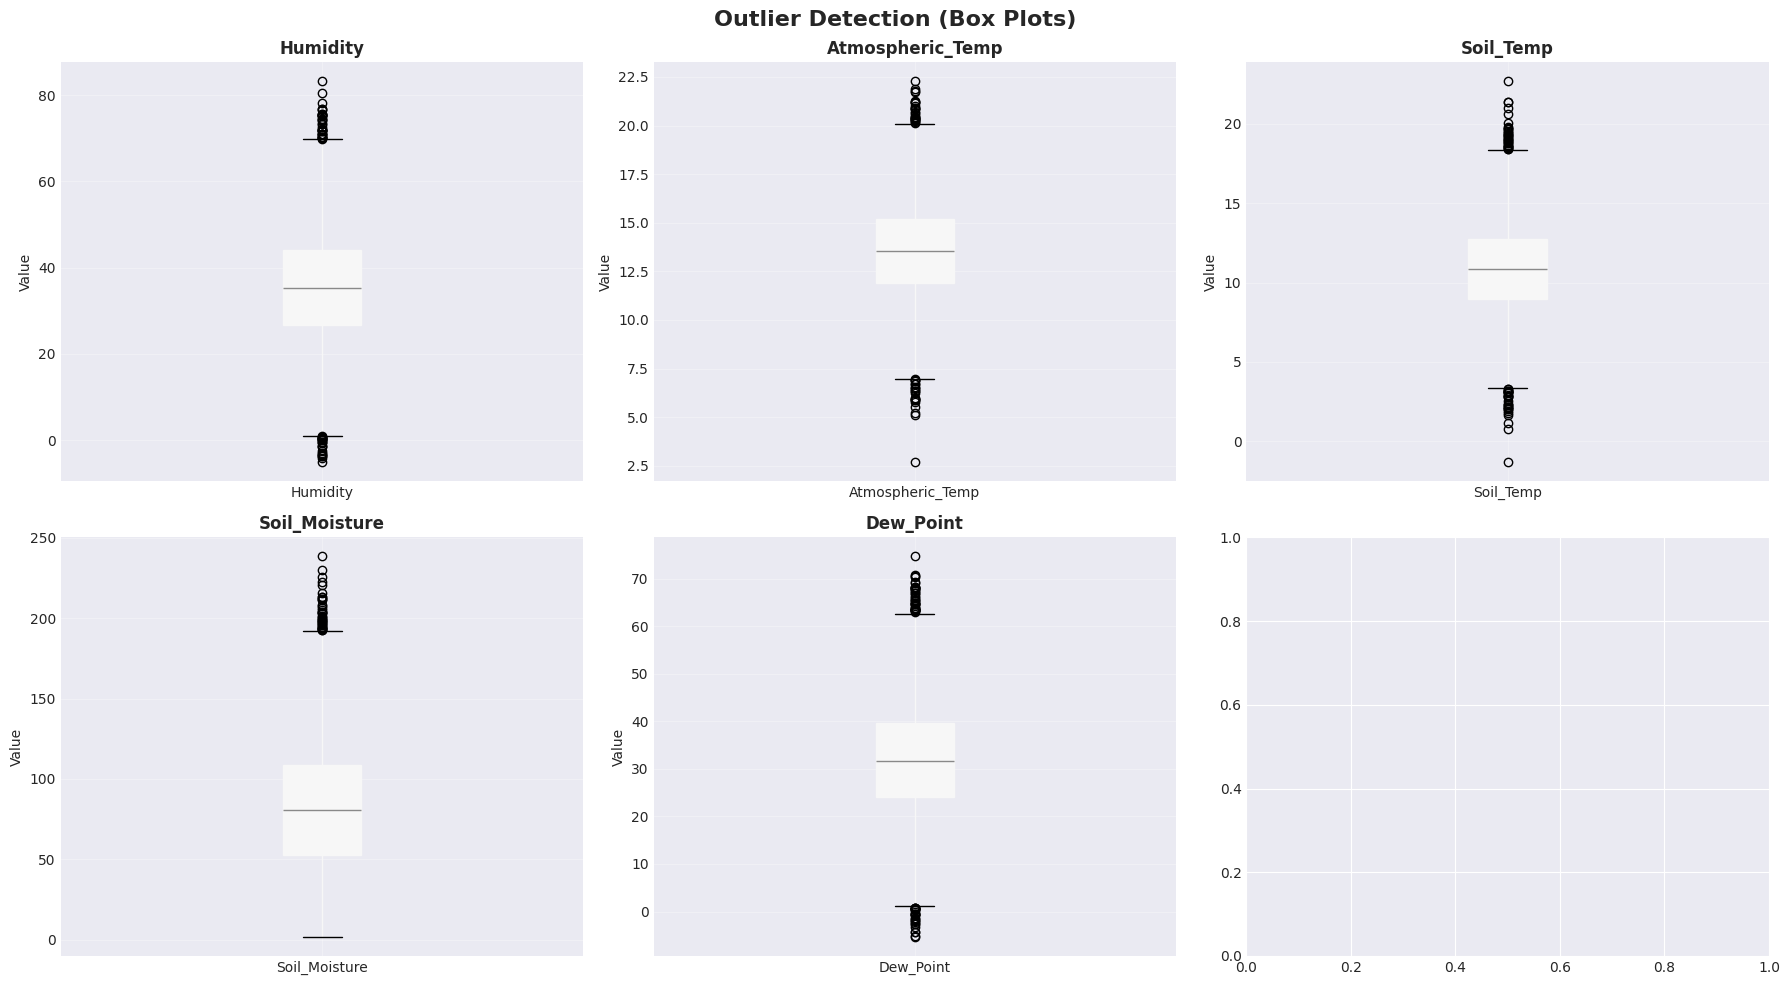


📊 Box plots generated


In [6]:
# Box plots for outlier detection
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Outlier Detection (Box Plots)', fontsize=16, fontweight='bold')

for idx, col in enumerate(df.columns):
    row = idx // 3
    col_idx = idx % 3
    ax = axes[row, col_idx]
    
    df.boxplot(column=col, ax=ax, patch_artist=True)
    ax.set_title(f'{col}', fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Box plots generated")

In [7]:
# Outlier analysis using IQR
print("=" * 80)
print("OUTLIER ANALYSIS (IQR METHOD)")
print("=" * 80)

outlier_summary = []

for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_pct = outliers / len(df) * 100
    
    outlier_summary.append({
        'Feature': col,
        'Outliers': outliers,
        'Percentage': f"{outlier_pct:.2f}%",
        'Lower_Bound': f"{lower_bound:.2f}",
        'Upper_Bound': f"{upper_bound:.2f}",
        'Min': f"{df[col].min():.2f}",
        'Max': f"{df[col].max():.2f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

OUTLIER ANALYSIS (IQR METHOD)


,Feature,Outliers,Percentage,Lower_Bound,Upper_Bound,Min,Max
0,Humidity,60,0.68%,0.97,69.88,-5.04,83.18
1,Atmospheric_Temp,49,0.56%,6.99,20.12,2.70,22.27
2,Soil_Temp,63,0.72%,3.32,18.35,-1.30,22.67
3,Soil_Moisture,40,0.46%,-30.87,192.23,1.69,238.43
4,Dew_Point,66,0.75%,0.90,62.92,-5.36,74.70


## 2. Data Cleaning

### Strategy:
1. **Missing values**: Interpolate gaps ≤3 hours (time-based linear interpolation)
2. **Outliers**: IQR method - replace with median
3. **Invalid ranges**: 
   - Humidity: Cap to 0-100%
   - Temperature: Cap to reasonable range (0-50°C)
   - Soil Moisture: Cap to sensor range (0-200, based on data)

In [8]:
# Create working copy
df_clean = df.copy()

print("Starting data cleaning...\n")
print(f"Original shape: {df_clean.shape}")

# 1. Handle missing values (interpolate gaps ≤3 hours)
print("\n[1/3] Handling missing values...")
missing_before = df_clean.isnull().sum().sum()

if missing_before > 0:
    # Time-based interpolation (max 3 hours gap)
    df_clean = df_clean.interpolate(method='time', limit=3, limit_direction='both')
    
    # Drop remaining missing values (large gaps)
    df_clean = df_clean.dropna()
    
    missing_after = df_clean.isnull().sum().sum()
    print(f"  Missing values: {missing_before} → {missing_after}")
    print(f"  Rows dropped: {len(df) - len(df_clean)}")
else:
    print("  ✓ No missing values to handle")

# 2. Handle outliers using IQR (replace with median)
print("\n[2/3] Handling outliers (IQR method)...")

for col in df_clean.columns:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outlier_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
    outlier_count = outlier_mask.sum()
    
    if outlier_count > 0:
        # Replace with median
        median_value = df_clean[col].median()
        df_clean.loc[outlier_mask, col] = median_value
        print(f"  {col}: {outlier_count} outliers replaced with median ({median_value:.2f})")

# 3. Cap invalid ranges
print("\n[3/3] Capping invalid ranges...")

# Humidity: 0-100%
humidity_capped = ((df_clean['Humidity'] < 0) | (df_clean['Humidity'] > 100)).sum()
df_clean['Humidity'] = df_clean['Humidity'].clip(0, 100)
print(f"  Humidity: {humidity_capped} values capped to [0, 100]")

# Temperature: 0-50°C (reasonable for tropical agriculture)
temp_cols = ['Atmospheric_Temp', 'Soil_Temp']
for col in temp_cols:
    temp_capped = ((df_clean[col] < 0) | (df_clean[col] > 50)).sum()
    df_clean[col] = df_clean[col].clip(0, 50)
    print(f"  {col}: {temp_capped} values capped to [0, 50]")

# Soil Moisture: Based on data distribution (0-200 seems reasonable for this sensor)
sm_capped = (df_clean['Soil_Moisture'] < 0).sum()
df_clean['Soil_Moisture'] = df_clean['Soil_Moisture'].clip(0, None)
print(f"  Soil_Moisture: {sm_capped} values capped to [0, inf]")

# Dew Point: Should be ≤ Atmospheric_Temp
df_clean['Dew_Point'] = df_clean[['Dew_Point', 'Atmospheric_Temp']].min(axis=1)

print(f"\n✓ Cleaning complete!")
print(f"Final shape: {df_clean.shape}")
print(f"Data retained: {len(df_clean)/len(df)*100:.2f}%")

Starting data cleaning...

Original shape: (8761, 5)

[1/3] Handling missing values...
  ✓ No missing values to handle

[2/3] Handling outliers (IQR method)...
  Humidity: 60 outliers replaced with median (35.25)
  Atmospheric_Temp: 49 outliers replaced with median (13.54)
  Soil_Temp: 63 outliers replaced with median (10.84)
  Soil_Moisture: 40 outliers replaced with median (80.64)
  Dew_Point: 66 outliers replaced with median (31.73)

[3/3] Capping invalid ranges...
  Humidity: 0 values capped to [0, 100]
  Atmospheric_Temp: 0 values capped to [0, 50]
  Soil_Temp: 0 values capped to [0, 50]
  Soil_Moisture: 0 values capped to [0, inf]

✓ Cleaning complete!
Final shape: (8761, 5)
Data retained: 100.00%


In [9]:
# Compare before/after statistics
print("=" * 80)
print("CLEANED DATA SUMMARY")
print("=" * 80)
display(df_clean.describe())

CLEANED DATA SUMMARY


,Humidity,Atmospheric_Temp,Soil_Temp,Soil_Moisture,Dew_Point
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000
mean,35.337586,13.538946,10.844476,82.394180,13.272778
std,12.396935,2.401199,2.715027,37.662855,2.590792
min,1.004476,6.988798,3.333531,1.694193,1.259282
25%,26.949574,11.926276,8.995559,52.788263,11.682837
50%,35.250999,13.538494,10.836569,80.637591,13.351778
75%,43.877832,15.173993,12.678895,107.997828,14.985271
max,69.874608,20.102751,18.343262,192.225501,20.102751


## 3. Feature Engineering

### Features to Create:
1. **Rolling statistics**: 3h, 6h, 12h windows for soil moisture, humidity, temperature
2. **Rate of change**: First-order differences
3. **Time-based features**: hour, day_of_week, is_daytime
4. **Season**: Yala (May-Aug) vs Maha (Sep-Mar)
5. **Rainfall proxy**: Humidity spike detection (sudden increase suggests rain)

### Why These Features Stand Out:
- **Temporal patterns**: Captures diurnal and seasonal variations
- **Dynamic behavior**: Rate of change shows trends (drying vs wetting)
- **Context-aware**: Time of day + season = irrigation scheduling intelligence
- **Rainfall detection**: Prevents unnecessary irrigation after rain

In [10]:
# Create feature-rich dataset
df_features = df_clean.copy()

print("Engineering features...\n")

# 1. Rolling statistics (3h, 6h, 12h windows)
print("[1/5] Creating rolling window features...")
rolling_features = ['Soil_Moisture', 'Humidity', 'Atmospheric_Temp']
windows = [3, 6, 12]

for feature in rolling_features:
    for window in windows:
        # Rolling mean
        df_features[f'{feature}_rolling_mean_{window}h'] = (
            df_features[feature].rolling(window=window, min_periods=1).mean()
        )
        # Rolling std (volatility)
        df_features[f'{feature}_rolling_std_{window}h'] = (
            df_features[feature].rolling(window=window, min_periods=1).std().fillna(0)
        )

print(f"  ✓ Created {len(rolling_features) * len(windows) * 2} rolling features")

# 2. Rate of change (first-order differences)
print("\n[2/5] Creating rate-of-change features...")
change_features = ['Soil_Moisture', 'Atmospheric_Temp', 'Humidity']

for feature in change_features:
    df_features[f'{feature}_change_1h'] = df_features[feature].diff(periods=1).fillna(0)
    df_features[f'{feature}_change_3h'] = df_features[feature].diff(periods=3).fillna(0)

print(f"  ✓ Created {len(change_features) * 2} rate-of-change features")

# 3. Time-based features
print("\n[3/5] Creating time-based features...")

df_features['hour_of_day'] = df_features.index.hour
df_features['day_of_week'] = df_features.index.dayofweek
df_features['is_daytime'] = ((df_features['hour_of_day'] >= 6) & 
                              (df_features['hour_of_day'] < 18)).astype(int)

# Cyclical encoding for hour (preserves 23→0 continuity)
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour_of_day'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour_of_day'] / 24)

print(f"  ✓ Created 5 time-based features (hour, day, daytime, sin/cos encoding)")

# 4. Season (Sri Lankan cropping seasons)
print("\n[4/5] Creating season feature...")

def get_season(month):
    """Yala: May-Aug, Maha: Sep-Apr"""
    if 5 <= month <= 8:
        return 'Yala'
    else:
        return 'Maha'

df_features['season'] = df_features.index.month.map(get_season)
df_features['is_yala_season'] = (df_features['season'] == 'Yala').astype(int)

print(f"  ✓ Created season feature (Yala: {(df_features['season']=='Yala').sum()}, Maha: {(df_features['season']=='Maha').sum()})")

# 5. Rainfall proxy (humidity spike detection)
print("\n[5/5] Creating rainfall proxy feature...")

# Sudden humidity increase (>10% in 1 hour) suggests rainfall
df_features['humidity_spike'] = (df_features['Humidity_change_1h'] > 10).astype(int)

# Recent rain (humidity spike in last 3 hours)
df_features['recent_rain'] = (
    df_features['humidity_spike'].rolling(window=3, min_periods=1).sum() > 0
).astype(int)

print(f"  ✓ Detected {df_features['humidity_spike'].sum()} humidity spikes (potential rainfall events)")

print(f"\n✓ Feature engineering complete!")
print(f"Total features: {len(df_features.columns)} (from original {len(df_clean.columns)})")
print(f"Shape: {df_features.shape}")

Engineering features...

[1/5] Creating rolling window features...
  ✓ Created 18 rolling features

[2/5] Creating rate-of-change features...
  ✓ Created 6 rate-of-change features

[3/5] Creating time-based features...
  ✓ Created 5 time-based features (hour, day, daytime, sin/cos encoding)

[4/5] Creating season feature...
  ✓ Created season feature (Yala: 2953, Maha: 5808)

[5/5] Creating rainfall proxy feature...
  ✓ Detected 2514 humidity spikes (potential rainfall events)

✓ Feature engineering complete!
Total features: 38 (from original 5)
Shape: (8761, 38)


In [11]:
# Display feature summary
print("=" * 80)
print("ENGINEERED FEATURES SUMMARY")
print("=" * 80)
print(f"\nFeature categories:")
print(f"  - Original features: {len(df_clean.columns)}")
print(f"  - Rolling statistics: {len([c for c in df_features.columns if 'rolling' in c])}")
print(f"  - Rate of change: {len([c for c in df_features.columns if 'change' in c])}")
print(f"  - Time-based: {len([c for c in df_features.columns if c in ['hour_of_day', 'day_of_week', 'is_daytime', 'hour_sin', 'hour_cos']])}")
print(f"  - Season: {len([c for c in df_features.columns if 'season' in c])}")
print(f"  - Rainfall proxy: {len([c for c in df_features.columns if 'rain' in c or 'humidity_spike' in c])}")
print(f"\nTotal: {len(df_features.columns)} features")

print("\nSample of engineered features:")
display(df_features[[
    'Soil_Moisture', 'Soil_Moisture_rolling_mean_6h', 'Soil_Moisture_change_1h',
    'Atmospheric_Temp', 'hour_of_day', 'is_daytime', 'season', 'recent_rain'
]].head(10))

ENGINEERED FEATURES SUMMARY

Feature categories:
  - Original features: 5
  - Rolling statistics: 18
  - Rate of change: 6
  - Time-based: 5
  - Season: 2
  - Rainfall proxy: 2

Total: 38 features

Sample of engineered features:


,Soil_Moisture,Soil_Moisture_rolling_mean_6h,Soil_Moisture_change_1h,Atmospheric_Temp,hour_of_day,is_daytime,season,recent_rain
Time,,,,,,,,
2017-06-11 21:00:21+00:00,63.077305,63.077305,0.000000,15.487149,21,0,Yala,0
2017-06-11 22:00:21+00:00,40.097357,51.587331,-22.979948,12.115891,22,0,Yala,0
2017-06-11 23:00:21+00:00,100.141916,67.772193,60.044560,17.319203,23,0,Yala,0
2017-06-12 00:00:21+00:00,64.638742,66.988830,-35.503174,15.865805,0,0,Yala,1
2017-06-12 01:00:21+00:00,97.964697,73.184003,33.325954,13.842739,1,0,Yala,1
2017-06-12 02:00:21+00:00,145.965866,85.314314,48.001169,11.841426,2,0,Yala,1
2017-06-12 03:00:21+00:00,114.717290,93.920978,-31.248576,18.202429,3,0,Yala,1
2017-06-12 04:00:21+00:00,114.929499,106.393002,0.212209,15.294173,4,0,Yala,1
2017-06-12 05:00:21+00:00,34.064293,95.380065,-80.865207,12.330851,5,0,Yala,0


## 4. Label Engineering (Multi-Class with Domain Intelligence)

### Intelligent Labeling Strategy:

Uses **dynamic quantile-based thresholds** combined with **multi-factor logic**:

```python
Priority 1: Check for recent rainfall
  → If recent_rain: No_Irrigation (avoid over-irrigation)

Priority 2: Soil moisture analysis
  → Very dry (<25th percentile) + High temp (>75th percentile):
      If daytime: Irrigate_High (urgent, but avoid midday stress)
      If nighttime: Irrigate_Low (less evaporation)
  
  → Moderately dry (25-50th percentile) + Moderate temp:
      Irrigate_Low
  
  → Sufficient moisture (>50th percentile):
      No_Irrigation
```

### Why This Stands Out:
1. **Context-aware**: Considers time, weather, and plant physiology
2. **Water efficient**: Prevents irrigation after rain
3. **Crop-safe**: Avoids high midday irrigation (leaf scorch risk)
4. **Adaptive**: Uses data distribution (not hardcoded values)
5. **Edge-friendly**: Simple boolean logic (fast inference)

In [12]:
# Calculate dynamic thresholds from data distribution
print("Calculating dynamic thresholds from data distribution...\n")

# Soil moisture percentiles
sm_p25 = df_features['Soil_Moisture'].quantile(0.25)
sm_p50 = df_features['Soil_Moisture'].quantile(0.50)
sm_p75 = df_features['Soil_Moisture'].quantile(0.75)

# Temperature percentiles
temp_p50 = df_features['Atmospheric_Temp'].quantile(0.50)
temp_p75 = df_features['Atmospheric_Temp'].quantile(0.75)

print(f"Soil Moisture thresholds:")
print(f"  - Very dry (P25): {sm_p25:.2f}")
print(f"  - Moderate (P50): {sm_p50:.2f}")
print(f"  - Sufficient (P75): {sm_p75:.2f}")
print(f"\nTemperature thresholds:")
print(f"  - Moderate (P50): {temp_p50:.2f}°C")
print(f"  - High (P75): {temp_p75:.2f}°C")

# Multi-factor labeling function
def create_irrigation_label(row):
    """
    Intelligent multi-class irrigation labeling.
    
    Priority hierarchy:
    1. Recent rainfall → No irrigation
    2. Soil moisture + temperature + time of day → Classify need
    """
    soil_moisture = row['Soil_Moisture']
    temp = row['Atmospheric_Temp']
    is_daytime = row['is_daytime']
    recent_rain = row['recent_rain']
    
    # Priority 1: Recent rainfall
    if recent_rain == 1:
        return 'No_Irrigation'
    
    # Priority 2: Soil moisture analysis
    # Case 1: Very dry soil
    if soil_moisture < sm_p25:
        if temp > temp_p75:  # Hot weather
            # High evaporation risk - urgent irrigation needed
            # But avoid midday irrigation (leaf burn risk)
            if is_daytime and (9 <= row['hour_of_day'] <= 15):
                return 'Irrigate_Low'  # Delay to early morning/evening
            else:
                return 'Irrigate_High'
        elif temp > temp_p50:  # Moderate temperature
            return 'Irrigate_High'
        else:  # Cool weather
            return 'Irrigate_Low'
    
    # Case 2: Moderately dry soil
    elif sm_p25 <= soil_moisture < sm_p50:
        if temp > temp_p75:  # Hot weather
            return 'Irrigate_Low'
        elif temp > temp_p50:  # Moderate temperature
            return 'Irrigate_Low'
        else:  # Cool weather
            return 'No_Irrigation'
    
    # Case 3: Sufficient moisture
    else:
        return 'No_Irrigation'

# Apply labeling
print("\nGenerating irrigation labels...")
df_features['Irrigation_Class'] = df_features.apply(create_irrigation_label, axis=1)

# Class distribution
print("\n" + "=" * 80)
print("IRRIGATION CLASS DISTRIBUTION")
print("=" * 80)
class_counts = df_features['Irrigation_Class'].value_counts()
class_pct = df_features['Irrigation_Class'].value_counts(normalize=True) * 100

class_summary = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_pct.round(2)
})
display(class_summary)

print(f"\n✓ Labels generated successfully!")
print(f"Total samples: {len(df_features)}")

Calculating dynamic thresholds from data distribution...

Soil Moisture thresholds:
  - Very dry (P25): 52.79
  - Moderate (P50): 80.64
  - Sufficient (P75): 108.00

Temperature thresholds:
  - Moderate (P50): 13.54°C
  - High (P75): 15.17°C

Generating irrigation labels...

IRRIGATION CLASS DISTRIBUTION


,Count,Percentage
Irrigation_Class,,
No_Irrigation,7845,89.54
Irrigate_Low,649,7.41
Irrigate_High,267,3.05



✓ Labels generated successfully!
Total samples: 8761


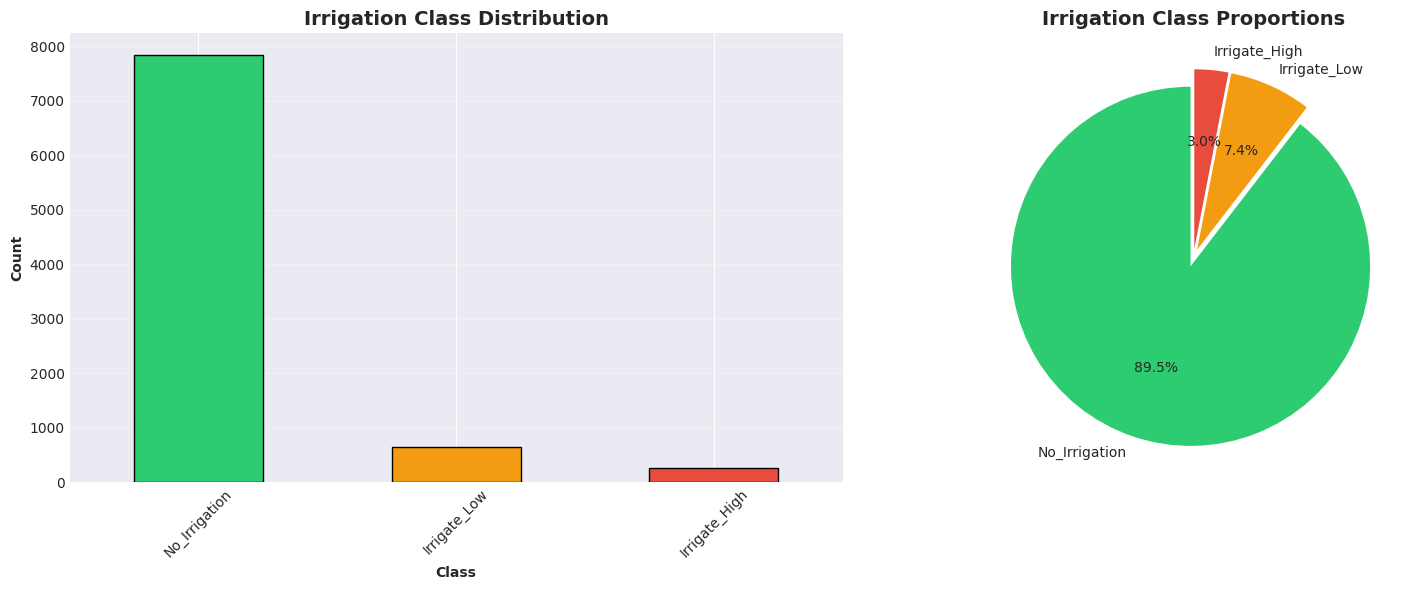


📊 Class distribution visualizations generated


In [13]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#f39c12', '#e74c3c'], edgecolor='black')
axes[0].set_title('Irrigation Class Distribution', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Class', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
class_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                  colors=['#2ecc71', '#f39c12', '#e74c3c'],
                  startangle=90, explode=[0.05, 0.05, 0.05])
axes[1].set_title('Irrigation Class Proportions', fontweight='bold', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("\n📊 Class distribution visualizations generated")

## 5. Feature Scaling & Encoding

### Scaling Strategy: StandardScaler

**Why StandardScaler?**
- Robust to outliers (already handled, but sensor noise remains)
- Preserves distribution shape (important for time-series)
- Better for distance-based and gradient-based algorithms
- Edge-friendly: Simple mean/std calculation for deployment

**What to scale:**
- All numeric features except categorical encodings (is_daytime, is_yala_season)
- Cyclical features (hour_sin, hour_cos) already normalized

**Deployment artifact:**
- Save scaler as `.pkl` for consistent preprocessing on Raspberry Pi

In [14]:
# Prepare features for scaling
print("Preparing features for scaling...\n")

# Separate features and target
X = df_features.copy()
y = X.pop('Irrigation_Class')

# Remove categorical string column (season) - keep encoded version
if 'season' in X.columns:
    X = X.drop('season', axis=1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Identify columns to scale (exclude binary/cyclical features)
binary_features = ['is_daytime', 'is_yala_season', 'humidity_spike', 'recent_rain']
cyclical_features = ['hour_sin', 'hour_cos']
exclude_from_scaling = binary_features + cyclical_features

features_to_scale = [col for col in X.columns if col not in exclude_from_scaling]

print(f"\nFeatures to scale: {len(features_to_scale)}")
print(f"Features excluded (binary/cyclical): {len(exclude_from_scaling)}")

# Initialize and fit scaler
print("\nFitting StandardScaler...")
scaler = StandardScaler()
X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

print(f"✓ Scaling complete!")

# Save scaler for edge deployment
scaler_path = DATA_PROCESSED / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved to: {scaler_path}")

# Save feature names (for deployment)
feature_names = list(X.columns)
feature_names_path = DATA_PROCESSED / 'feature_names.json'
with open(feature_names_path, 'w') as f:
    json.dump(feature_names, f, indent=2)
print(f"✓ Feature names saved to: {feature_names_path}")

# Save scaling metadata
scaling_metadata = {
    'scaler_type': 'StandardScaler',
    'features_scaled': features_to_scale,
    'features_excluded': exclude_from_scaling,
    'total_features': len(X.columns)
}
metadata_path = DATA_PROCESSED / 'scaling_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(scaling_metadata, f, indent=2)
print(f"✓ Scaling metadata saved to: {metadata_path}")

Preparing features for scaling...

Features shape: (8761, 37)
Target shape: (8761,)

Features to scale: 31
Features excluded (binary/cyclical): 6

Fitting StandardScaler...
✓ Scaling complete!
✓ Scaler saved to: /home/tehaan/projects/fyp-agro-edge-ai/data/processed/scaler.pkl
✓ Feature names saved to: /home/tehaan/projects/fyp-agro-edge-ai/data/processed/feature_names.json
✓ Scaling metadata saved to: /home/tehaan/projects/fyp-agro-edge-ai/data/processed/scaling_metadata.json


In [15]:
# Verify scaling (check mean≈0, std≈1 for scaled features)
print("=" * 80)
print("SCALING VERIFICATION")
print("=" * 80)
print("\nScaled features statistics (should have mean≈0, std≈1):")
scaled_stats = X[features_to_scale[:5]].describe().loc[['mean', 'std']]
display(scaled_stats)

print("\nBinary features (unchanged):")
binary_stats = X[binary_features].describe().loc[['mean', 'min', 'max']]
display(binary_stats)

SCALING VERIFICATION

Scaled features statistics (should have mean≈0, std≈1):


,Humidity,Atmospheric_Temp,Soil_Temp,Soil_Moisture,Dew_Point
mean,6.455793e-16,-3.540143e-16,6.500400e-16,1.244930e-16,3.430654e-16
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00



Binary features (unchanged):


,is_daytime,is_yala_season,humidity_spike,recent_rain
mean,0.499943,0.337062,0.286954,0.722977
min,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


## 6. Time-Series Windowing

### Windowing Strategy:

**Configuration:**
- **Window size**: 6 hours (captures short-term + diurnal patterns)
- **Stride**: 1 hour (dense sampling for responsive irrigation)
- **Target**: Current hour's irrigation class

**Why 6 hours?**
- Captures recent moisture/temperature trends
- Includes multiple irrigation cycles
- Memory-efficient: 6h × 50 features × 4 bytes = 1.2KB per sample
- Pi 4B friendly: Can hold thousands of samples in RAM

**Output:**
- `X_windowed`: (num_samples, 6, num_features) - 3D tensor for LSTM/GRU
- `X_flat`: (num_samples, 6 * num_features) - 2D for traditional ML
- `y_windowed`: (num_samples,) - corresponding labels

In [16]:
# Time-series windowing parameters
WINDOW_SIZE = 6  # hours
STRIDE = 1       # hours

print(f"Creating time-series windows...")
print(f"  Window size: {WINDOW_SIZE} hours")
print(f"  Stride: {STRIDE} hour(s)")
print(f"  Input shape: {X.shape}")
print(f"  Target shape: {y.shape}\n")

# Windowing function
def create_windows(X, y, window_size, stride):
    """
    Create sliding windows for time-series data.
    
    Returns:
    - X_windowed: 3D array (samples, window_size, features)
    - y_windowed: 1D array (samples,)
    - timestamps: Index values for each window
    """
    X_windows = []
    y_windows = []
    timestamps = []
    
    for i in range(0, len(X) - window_size + 1, stride):
        # Extract window
        X_window = X.iloc[i:i+window_size].values
        y_window = y.iloc[i+window_size-1]  # Target is last timestep
        timestamp = y.index[i+window_size-1]
        
        X_windows.append(X_window)
        y_windows.append(y_window)
        timestamps.append(timestamp)
    
    return np.array(X_windows), np.array(y_windows), timestamps

# Create windows
X_windowed, y_windowed, timestamps = create_windows(X, y, WINDOW_SIZE, STRIDE)

print(f"✓ Windowing complete!")
print(f"\nWindow statistics:")
print(f"  X_windowed shape: {X_windowed.shape} (samples, window_size, features)")
print(f"  y_windowed shape: {y_windowed.shape}")
print(f"  Total windows: {len(X_windowed):,}")
print(f"  Window coverage: {len(X_windowed) / len(X) * 100:.2f}% of original data")

# Memory footprint estimate
memory_per_sample = X_windowed[0].nbytes
total_memory = X_windowed.nbytes / (1024**2)  # MB
print(f"\nMemory footprint:")
print(f"  Per sample: {memory_per_sample / 1024:.2f} KB")
print(f"  Total dataset: {total_memory:.2f} MB")
print(f"  Pi 4B impact: {total_memory / (4*1024) * 100:.2f}% of 4GB RAM")

Creating time-series windows...
  Window size: 6 hours
  Stride: 1 hour(s)
  Input shape: (8761, 37)
  Target shape: (8761,)

✓ Windowing complete!

Window statistics:
  X_windowed shape: (8756, 6, 37) (samples, window_size, features)
  y_windowed shape: (8756,)
  Total windows: 8,756
  Window coverage: 99.94% of original data

Memory footprint:
  Per sample: 1.73 KB
  Total dataset: 14.83 MB
  Pi 4B impact: 0.36% of 4GB RAM


In [17]:
# Create flattened version for traditional ML models
print("Creating flattened version for traditional ML...\n")

X_flat = X_windowed.reshape(X_windowed.shape[0], -1)

print(f"X_flat shape: {X_flat.shape} (samples, window_size * features)")
print(f"Feature dimension: {X_flat.shape[1]:,} (6h × {X.shape[1]} features)")

print(f"\n✓ Both formats ready:")
print(f"  - X_windowed: For LSTM/GRU/RNN models")
print(f"  - X_flat: For DecisionTree/RandomForest/XGBoost")

Creating flattened version for traditional ML...

X_flat shape: (8756, 222) (samples, window_size * features)
Feature dimension: 222 (6h × 37 features)

✓ Both formats ready:
  - X_windowed: For LSTM/GRU/RNN models
  - X_flat: For DecisionTree/RandomForest/XGBoost


In [18]:
# Verify class distribution in windowed data
print("=" * 80)
print("CLASS DISTRIBUTION (WINDOWED DATA)")
print("=" * 80)

windowed_class_counts = pd.Series(y_windowed).value_counts()
windowed_class_pct = pd.Series(y_windowed).value_counts(normalize=True) * 100

windowed_class_summary = pd.DataFrame({
    'Count': windowed_class_counts,
    'Percentage': windowed_class_pct.round(2)
})
display(windowed_class_summary)

CLASS DISTRIBUTION (WINDOWED DATA)


,Count,Percentage
No_Irrigation,7842,89.56
Irrigate_Low,647,7.39
Irrigate_High,267,3.05


## 7. Train/Test Split & Export

### Split Strategy:
- **80% Train / 20% Test** (chronological split)
- **No random shuffling**: Respects temporal order
- **Prevents leakage**: Test set is strictly future data

### Exports:
1. **CSV files**: `train.csv`, `test.csv` (non-windowed, for inspection)
2. **NumPy arrays**: Windowed data for model training
3. **Deployment artifacts**: Scaler, feature names, metadata

In [19]:
# Chronological train/test split (80/20)
print("Creating chronological train/test split...\n")

split_idx = int(0.8 * len(X_windowed))

# Split windowed data
X_train_windowed = X_windowed[:split_idx]
X_test_windowed = X_windowed[split_idx:]
y_train_windowed = y_windowed[:split_idx]
y_test_windowed = y_windowed[split_idx:]
timestamps_train = timestamps[:split_idx]
timestamps_test = timestamps[split_idx:]

# Split flat data
X_train_flat = X_flat[:split_idx]
X_test_flat = X_flat[split_idx:]

print(f"✓ Split complete!")
print(f"\nTrain set:")
print(f"  X_train_windowed: {X_train_windowed.shape}")
print(f"  X_train_flat: {X_train_flat.shape}")
print(f"  y_train: {y_train_windowed.shape}")
print(f"  Date range: {timestamps_train[0]} to {timestamps_train[-1]}")

print(f"\nTest set:")
print(f"  X_test_windowed: {X_test_windowed.shape}")
print(f"  X_test_flat: {X_test_flat.shape}")
print(f"  y_test: {y_test_windowed.shape}")
print(f"  Date range: {timestamps_test[0]} to {timestamps_test[-1]}")

# Verify no temporal leakage
print(f"\n✓ Temporal integrity check:")
print(f"  Last train timestamp: {timestamps_train[-1]}")
print(f"  First test timestamp: {timestamps_test[0]}")
print(f"  No leakage: {timestamps_train[-1] < timestamps_test[0]}")

Creating chronological train/test split...

✓ Split complete!

Train set:
  X_train_windowed: (7004, 6, 37)
  X_train_flat: (7004, 222)
  y_train: (7004,)
  Date range: 2017-06-12 02:00:21+00:00 to 2018-03-30 21:00:21+00:00

Test set:
  X_test_windowed: (1752, 6, 37)
  X_test_flat: (1752, 222)
  y_test: (1752,)
  Date range: 2018-03-30 22:00:21+00:00 to 2018-06-11 21:00:21+00:00

✓ Temporal integrity check:
  Last train timestamp: 2018-03-30 21:00:21+00:00
  First test timestamp: 2018-03-30 22:00:21+00:00
  No leakage: True


In [20]:
# Class distribution in train/test sets
print("=" * 80)
print("TRAIN/TEST CLASS DISTRIBUTION")
print("=" * 80)

train_class_counts = pd.Series(y_train_windowed).value_counts()
test_class_counts = pd.Series(y_test_windowed).value_counts()

class_dist = pd.DataFrame({
    'Train_Count': train_class_counts,
    'Train_Pct': (train_class_counts / len(y_train_windowed) * 100).round(2),
    'Test_Count': test_class_counts,
    'Test_Pct': (test_class_counts / len(y_test_windowed) * 100).round(2)
})
display(class_dist)

TRAIN/TEST CLASS DISTRIBUTION


,Train_Count,Train_Pct,Test_Count,Test_Pct
No_Irrigation,6288,89.78,1554,88.70
Irrigate_Low,510,7.28,137,7.82
Irrigate_High,206,2.94,61,3.48


In [21]:
# Export datasets
print("Exporting processed datasets...\n")

# 1. Export non-windowed data as CSV (for inspection)
print("[1/3] Exporting CSV files...")
train_df = pd.concat([X.iloc[:split_idx], y.iloc[:split_idx]], axis=1)
test_df = pd.concat([X.iloc[split_idx:], y.iloc[split_idx:]], axis=1)

train_csv_path = DATA_PROCESSED / 'train.csv'
test_csv_path = DATA_PROCESSED / 'test.csv'
train_df.to_csv(train_csv_path)
test_df.to_csv(test_csv_path)
print(f"  ✓ {train_csv_path}")
print(f"  ✓ {test_csv_path}")

# 2. Export windowed data as NumPy arrays
print("\n[2/3] Exporting windowed NumPy arrays...")
np.save(DATA_PROCESSED / 'X_train_windowed.npy', X_train_windowed)
np.save(DATA_PROCESSED / 'X_test_windowed.npy', X_test_windowed)
np.save(DATA_PROCESSED / 'X_train_flat.npy', X_train_flat)
np.save(DATA_PROCESSED / 'X_test_flat.npy', X_test_flat)
np.save(DATA_PROCESSED / 'y_train.npy', y_train_windowed)
np.save(DATA_PROCESSED / 'y_test.npy', y_test_windowed)
print(f"  ✓ X_train_windowed.npy")
print(f"  ✓ X_test_windowed.npy")
print(f"  ✓ X_train_flat.npy")
print(f"  ✓ X_test_flat.npy")
print(f"  ✓ y_train.npy")
print(f"  ✓ y_test.npy")

# 3. Export preprocessing metadata
print("\n[3/3] Exporting preprocessing metadata...")
preprocessing_metadata = {
    'dataset': 'soil_and_rain_data.csv',
    'preprocessing_date': datetime.now().isoformat(),
    'original_shape': {'rows': len(df), 'cols': len(df.columns)},
    'cleaned_shape': {'rows': len(df_clean), 'cols': len(df_clean.columns)},
    'feature_engineered_shape': {'rows': len(df_features), 'cols': len(df_features.columns) - 1},  # -1 for target
    'windowing': {
        'window_size': WINDOW_SIZE,
        'stride': STRIDE,
        'num_windows': len(X_windowed)
    },
    'split': {
        'train_size': len(X_train_windowed),
        'test_size': len(X_test_windowed),
        'train_date_range': [str(timestamps_train[0]), str(timestamps_train[-1])],
        'test_date_range': [str(timestamps_test[0]), str(timestamps_test[-1])]
    },
    'class_distribution': {
        'train': train_class_counts.to_dict(),
        'test': test_class_counts.to_dict()
    },
    'thresholds': {
        'soil_moisture': {'p25': float(sm_p25), 'p50': float(sm_p50), 'p75': float(sm_p75)},
        'temperature': {'p50': float(temp_p50), 'p75': float(temp_p75)}
    }
}

metadata_full_path = DATA_PROCESSED / 'preprocessing_metadata.json'
with open(metadata_full_path, 'w') as f:
    json.dump(preprocessing_metadata, f, indent=2)
print(f"  ✓ {metadata_full_path}")

print(f"\n✓ All datasets exported successfully!")
print(f"\n📁 Output directory: {DATA_PROCESSED}")

Exporting processed datasets...

[1/3] Exporting CSV files...
  ✓ /home/tehaan/projects/fyp-agro-edge-ai/data/processed/train.csv
  ✓ /home/tehaan/projects/fyp-agro-edge-ai/data/processed/test.csv

[2/3] Exporting windowed NumPy arrays...
  ✓ X_train_windowed.npy
  ✓ X_test_windowed.npy
  ✓ X_train_flat.npy
  ✓ X_test_flat.npy
  ✓ y_train.npy
  ✓ y_test.npy

[3/3] Exporting preprocessing metadata...
  ✓ /home/tehaan/projects/fyp-agro-edge-ai/data/processed/preprocessing_metadata.json

✓ All datasets exported successfully!

📁 Output directory: /home/tehaan/projects/fyp-agro-edge-ai/data/processed


## 8. Diagnostics & Visualizations

Generating correlation heatmap...



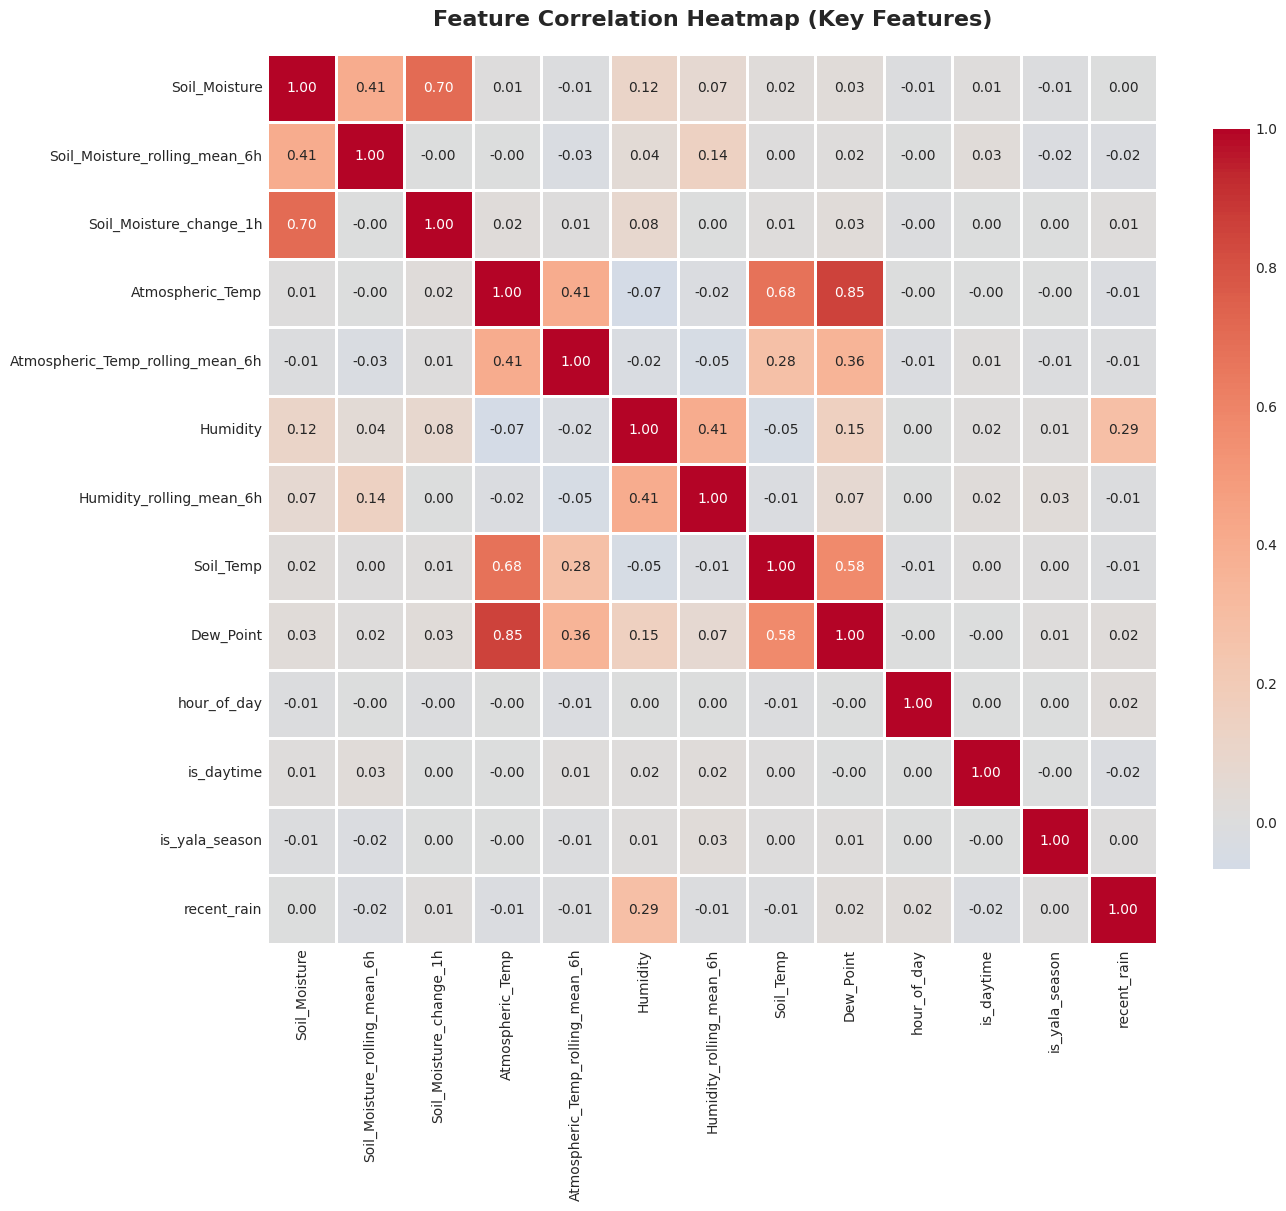


📊 Correlation heatmap generated


In [22]:
# Correlation heatmap (top features)
print("Generating correlation heatmap...\n")

# Select subset of key features for readability
key_features = [
    'Soil_Moisture', 'Soil_Moisture_rolling_mean_6h', 'Soil_Moisture_change_1h',
    'Atmospheric_Temp', 'Atmospheric_Temp_rolling_mean_6h',
    'Humidity', 'Humidity_rolling_mean_6h',
    'Soil_Temp', 'Dew_Point',
    'hour_of_day', 'is_daytime', 'is_yala_season', 'recent_rain'
]

correlation_matrix = train_df[key_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap (Key Features)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n📊 Correlation heatmap generated")

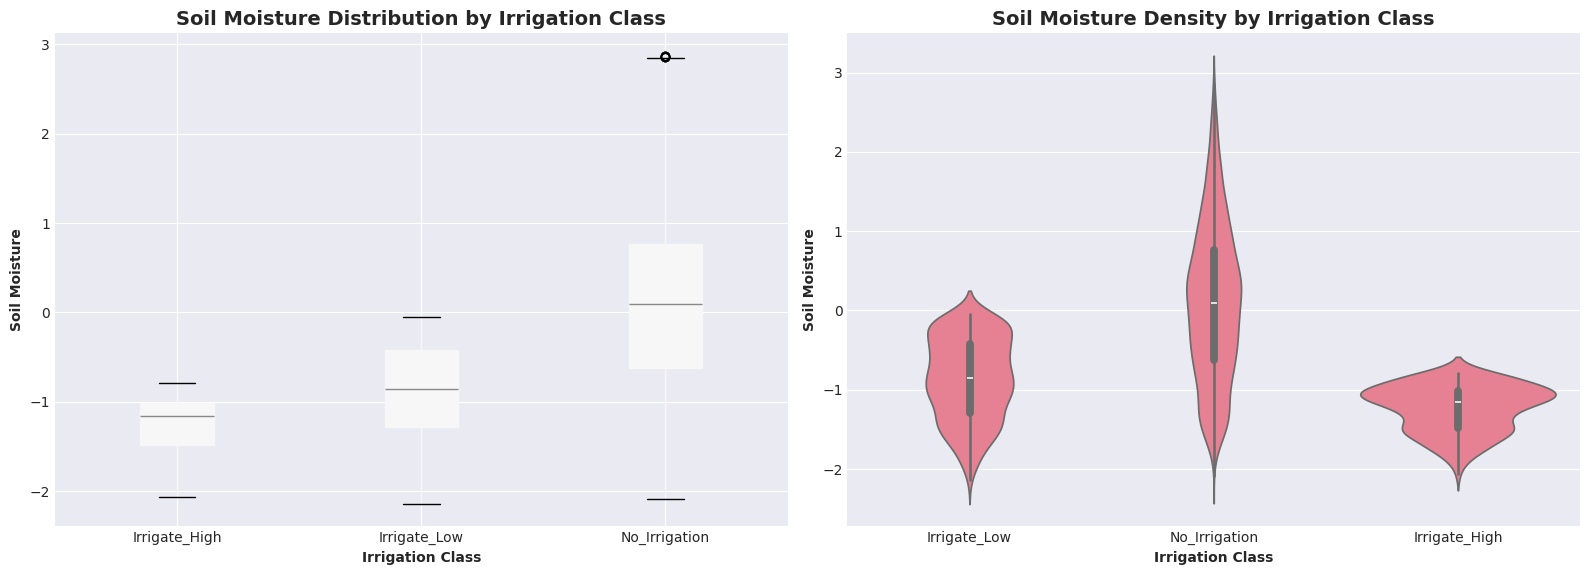


📊 Soil moisture vs irrigation class visualizations generated


In [23]:
# Soil moisture vs irrigation class
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
train_df.boxplot(column='Soil_Moisture', by='Irrigation_Class', ax=axes[0], patch_artist=True)
axes[0].set_title('Soil Moisture Distribution by Irrigation Class', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Irrigation Class', fontweight='bold')
axes[0].set_ylabel('Soil Moisture', fontweight='bold')
axes[0].get_figure().suptitle('')  # Remove default title

# Violin plot
sns.violinplot(data=train_df, x='Irrigation_Class', y='Soil_Moisture', ax=axes[1])
axes[1].set_title('Soil Moisture Density by Irrigation Class', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Irrigation Class', fontweight='bold')
axes[1].set_ylabel('Soil Moisture', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Soil moisture vs irrigation class visualizations generated")

Calculating feature importance (quick assessment)...



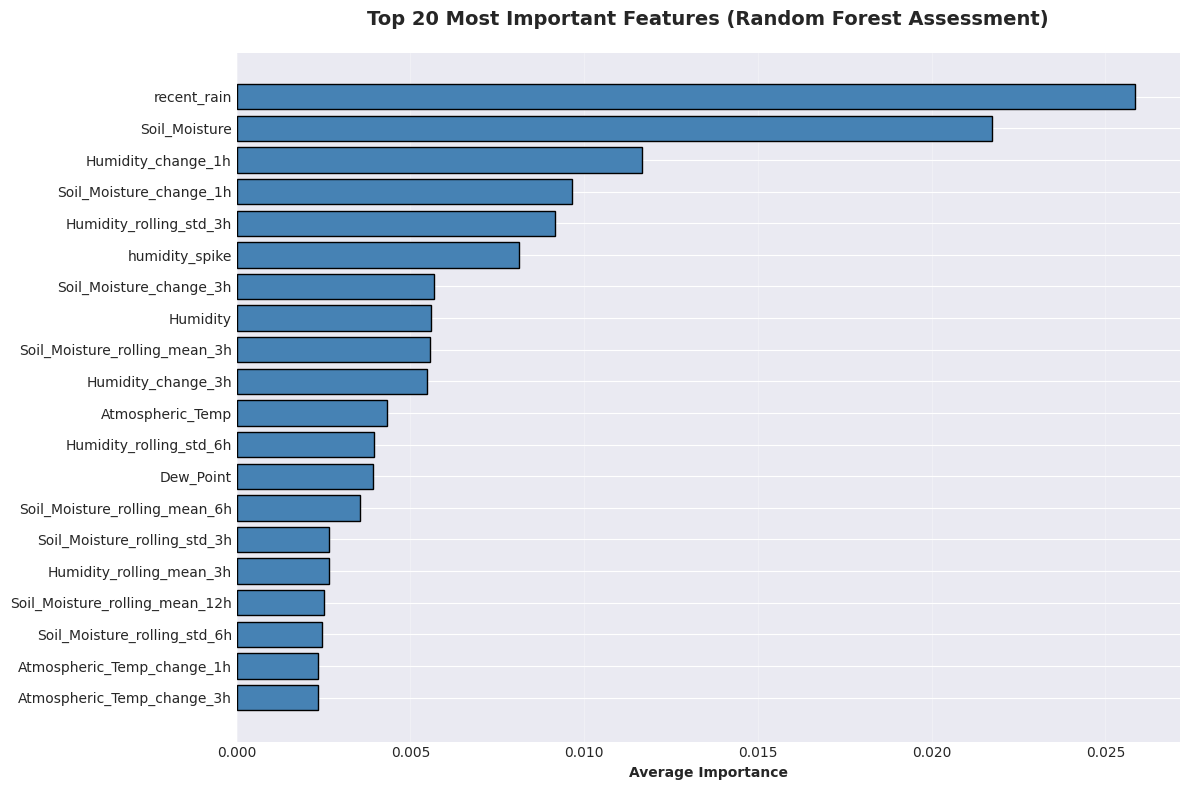


📊 Feature importance plot generated

Top 10 most important features:


,Feature,Importance
36,recent_rain,0.025854
3,Soil_Moisture,0.021750
27,Humidity_change_1h,0.011656
23,Soil_Moisture_change_1h,0.009662
12,Humidity_rolling_std_3h,0.009152
35,humidity_spike,0.008114
24,Soil_Moisture_change_3h,0.005684
0,Humidity,0.005582
5,Soil_Moisture_rolling_mean_3h,0.005579
28,Humidity_change_3h,0.005485


In [24]:
# Feature importance preview (using random forest for quick assessment)
print("Calculating feature importance (quick assessment)...\n")

from sklearn.ensemble import RandomForestClassifier

# Train quick RF model on flat data
rf_quick = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_quick.fit(X_train_flat, y_train_windowed)

# Get feature importance (averaged across window)
# Note: X_flat has shape (samples, window_size * features)
# We'll aggregate importance by original feature
feature_importance = rf_quick.feature_importances_

# Reshape to (window_size, num_features) and average across time
num_features = len(feature_names)
importance_matrix = feature_importance.reshape(WINDOW_SIZE, num_features)
avg_importance = importance_matrix.mean(axis=0)

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['Importance'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Average Importance', fontweight='bold')
plt.title('Top 20 Most Important Features (Random Forest Assessment)', 
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📊 Feature importance plot generated")
print("\nTop 10 most important features:")
display(importance_df.head(10))

In [25]:
# Final summary report
print("=" * 80)
print("PREPROCESSING SUMMARY REPORT")
print("=" * 80)

print(f"\n📊 Dataset Overview:")
print(f"  - Original rows: {len(df):,}")
print(f"  - After cleaning: {len(df_clean):,} ({len(df_clean)/len(df)*100:.2f}% retained)")
print(f"  - After windowing: {len(X_windowed):,} samples")
print(f"  - Train samples: {len(X_train_windowed):,} (80%)")
print(f"  - Test samples: {len(X_test_windowed):,} (20%)")

print(f"\n🔧 Feature Engineering:")
print(f"  - Original features: 5")
print(f"  - Engineered features: {len(feature_names)}")
print(f"  - Rolling windows: 3h, 6h, 12h")
print(f"  - Rate of change: 1h, 3h")
print(f"  - Time-based: hour, day, daytime, cyclical encoding")
print(f"  - Season: Yala/Maha")
print(f"  - Rainfall proxy: Humidity spike detection")

print(f"\n🎯 Label Distribution (Test Set):")
for class_name, count in test_class_counts.items():
    pct = count / len(y_test_windowed) * 100
    print(f"  - {class_name}: {count:,} ({pct:.2f}%)")

print(f"\n💾 Memory Footprint:")
print(f"  - Windowed data: {X_windowed.nbytes / (1024**2):.2f} MB")
print(f"  - Flat data: {X_flat.nbytes / (1024**2):.2f} MB")
print(f"  - Per sample: {X_windowed[0].nbytes / 1024:.2f} KB")
print(f"  - Pi 4B compatible: ✓ ({X_windowed.nbytes / (4*1024**3) * 100:.2f}% of 4GB RAM)")

print(f"\n🚀 Next Steps:")
print(f"  1. Train models using windowed data:")
print(f"     - Decision Tree on X_train_flat")
print(f"     - Random Forest on X_train_flat")
print(f"     - LSTM/GRU on X_train_windowed (optional, for comparison)")
print(f"  2. Evaluate on test set (X_test_flat / X_test_windowed)")
print(f"  3. Convert best model to edge format (pkl or ONNX)")
print(f"  4. Deploy on Raspberry Pi with scaler.pkl")

print(f"\n✓ Preprocessing pipeline complete!")
print(f"📁 All outputs saved to: {DATA_PROCESSED}")
print("=" * 80)

PREPROCESSING SUMMARY REPORT

📊 Dataset Overview:
  - Original rows: 8,761
  - After cleaning: 8,761 (100.00% retained)
  - After windowing: 8,756 samples
  - Train samples: 7,004 (80%)
  - Test samples: 1,752 (20%)

🔧 Feature Engineering:
  - Original features: 5
  - Engineered features: 37
  - Rolling windows: 3h, 6h, 12h
  - Rate of change: 1h, 3h
  - Time-based: hour, day, daytime, cyclical encoding
  - Season: Yala/Maha
  - Rainfall proxy: Humidity spike detection

🎯 Label Distribution (Test Set):
  - No_Irrigation: 1,554 (88.70%)
  - Irrigate_Low: 137 (7.82%)
  - Irrigate_High: 61 (3.48%)

💾 Memory Footprint:
  - Windowed data: 14.83 MB
  - Flat data: 14.83 MB
  - Per sample: 1.73 KB
  - Pi 4B compatible: ✓ (0.36% of 4GB RAM)

🚀 Next Steps:
  1. Train models using windowed data:
     - Decision Tree on X_train_flat
     - Random Forest on X_train_flat
     - LSTM/GRU on X_train_windowed (optional, for comparison)
  2. Evaluate on test set (X_test_flat / X_test_windowed)
  3. Conv